# Which features of houses impact the sale price?

In [166]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

## Importing the CSV file and having a first look at the data

In [73]:
housing = pd.read_csv("train.csv")

In [74]:
# Let's make a copy before we do any adjustments

housing_copy = housing.copy()

In [75]:
# housing.head() shows only partial data

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(housing.head(20))

    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0    1          60       RL         65.0     8450   Pave   NaN      Reg   
1    2          20       RL         80.0     9600   Pave   NaN      Reg   
2    3          60       RL         68.0    11250   Pave   NaN      IR1   
3    4          70       RL         60.0     9550   Pave   NaN      IR1   
4    5          60       RL         84.0    14260   Pave   NaN      IR1   
5    6          50       RL         85.0    14115   Pave   NaN      IR1   
6    7          20       RL         75.0    10084   Pave   NaN      Reg   
7    8          60       RL          NaN    10382   Pave   NaN      IR1   
8    9          50       RM         51.0     6120   Pave   NaN      Reg   
9   10         190       RL         50.0     7420   Pave   NaN      Reg   
10  11          20       RL         70.0    11200   Pave   NaN      Reg   
11  12          60       RL         85.0    11924   Pave   NaN      IR1   
12  13          20       

Inspecting the columns: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
The data is for Ames city in Iowa, USA. Therefore, the measurements are in feet and the prices in Dollars

In [76]:
housing.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [153]:
# 1460 rows, 81 columns

housing.shape

(1460, 81)

### Checking for NULL values. Remove columns which have more than 80% of missing values

In [78]:
# Quick check

housing.isna().sum().sort_values(ascending = False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64

In [79]:
# First checked row by row --> not efficient:
# [not housing.iloc[i,:].isna().sum() / len(housing) > 0.80 for i in range(0,len(housing))]

# Affected columns: PoolQC, MiscFeature, Alley, Fence

housing.isna().sum().sort_values(ascending = False)/len(housing) > 0.8

PoolQC            True
MiscFeature       True
Alley             True
Fence             True
FireplaceQu      False
                 ...  
CentralAir       False
SaleCondition    False
Heating          False
TotalBsmtSF      False
Id               False
Length: 81, dtype: bool

In [81]:
# Drop affected columns

housing_copy = housing_copy.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

In [82]:
# Total of 4 columns dropped, column length went from 81 to 77

housing_copy.shape

(1460, 77)

In [83]:
# Quick check of the datatypes

housing.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [84]:
# Check full dataframe
# Won't do anything with 'misclassified' columns yet, only later if I decide to work with these columns

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(housing_copy.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


## Check skewness of the dependent variable SalePrice

The dependent variable SalePrice is positively skewed, it has a longer tail on the right. This means that the mean of the data will be greater than the median based on the central limit theorem. The samling distribution of this skewed population distribution will become normally distributed. Therefore, there is no need to fix the skewed distribution in this scenario. 

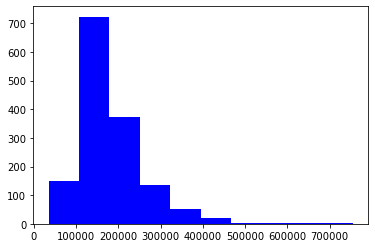

In [85]:
plt.hist(housing_copy.SalePrice, color='blue')
plt.show()

In [86]:
housing_copy.SalePrice.skew()

1.8828757597682129

## Check the correlation of different factors on the sale price

### Correlation of columns with numerical values

In [87]:
# housing_copy.corr()["SalePrice"] < -0.70 --> none
# housing_copy.corr()["SalePrice"] > 0.70

# 2 affected factors: GrLivArea & OverallQual

housing_copy.corr()["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

### Highest correlation: OverallQual has a positive correlation of 0.790982

In [88]:
# OverallQual: Overall material and finish quality
# Let's check the different values of the column
# Seems like the houses are rated on a scale from 1 - 10

housing_copy["OverallQual"].unique()
housing_copy["OverallQual"].value_counts().sort_values(ascending=False)

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

### Started with manual calculations

Mean

In [94]:
housing_copy["OverallQual"].mean()

6.0993150684931505

In [95]:
housing_copy["SalePrice"].mean()

180921.19589041095

Variance

In [96]:
ddof = 1

In [97]:
housing_copy["OverallQual"].var(ddof=ddof)

1.9126794482991725

In [98]:
housing_copy["SalePrice"].var(ddof=ddof)

6311111264.297448

Standard deviation

In [99]:
housing_copy["OverallQual"].std(ddof=ddof)

1.3829965467415934

In [100]:
housing_copy["SalePrice"].std(ddof=ddof)

79442.50288288662

Covariance

In [101]:
np.cov(housing_copy["OverallQual"], housing_copy["SalePrice"], ddof=ddof)

array([[1.91267945e+00, 8.69041258e+04],
       [8.69041258e+04, 6.31111126e+09]])

In [102]:
cov = np.cov(housing_copy["OverallQual"], housing_copy["SalePrice"], ddof=ddof)

In [103]:
cov[0,1]

86904.12583679947

Realized it wasn't necessary to calculate all the above values manually. The following methods incorporate the necessary values and gives us the right information. 

In [107]:
x = sm.add_constant(housing_copy.OverallQual)
model = sm.OLS(housing_copy.SalePrice, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2437.
Date:                Sat, 12 Sep 2020   Prob (F-statistic):          2.19e-313
Time:                        14:18:35   Log-Likelihood:                -17827.
No. Observations:                1460   AIC:                         3.566e+04
Df Residuals:                    1458   BIC:                         3.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.621e+04   5756.407    -16.713      

low: 0-0.3 / moderate: 0.3-0.7 / high: 0.7-1

R-squared: 0.626
        
We look at the R-squared, because, besides the dependent variable SalePrice, we only take one extra factor in consideration. The R squared of 0.626 indicates that the overall material and finish quality of the house account for 62,6% of variation in sale price. This R squared falls in the bracket of 0.3-0.7 and is therefore a moderate positive correlation.

Given our data, assuming the null hypothesis (which is 0), the likelihood of obtaining the regression coefficient that we observed or more extreme is 0.000. Since this is below the Alpha level of 5%, it is statistically significant and we can reject the null hypothesis.

### Let's show it with a graph

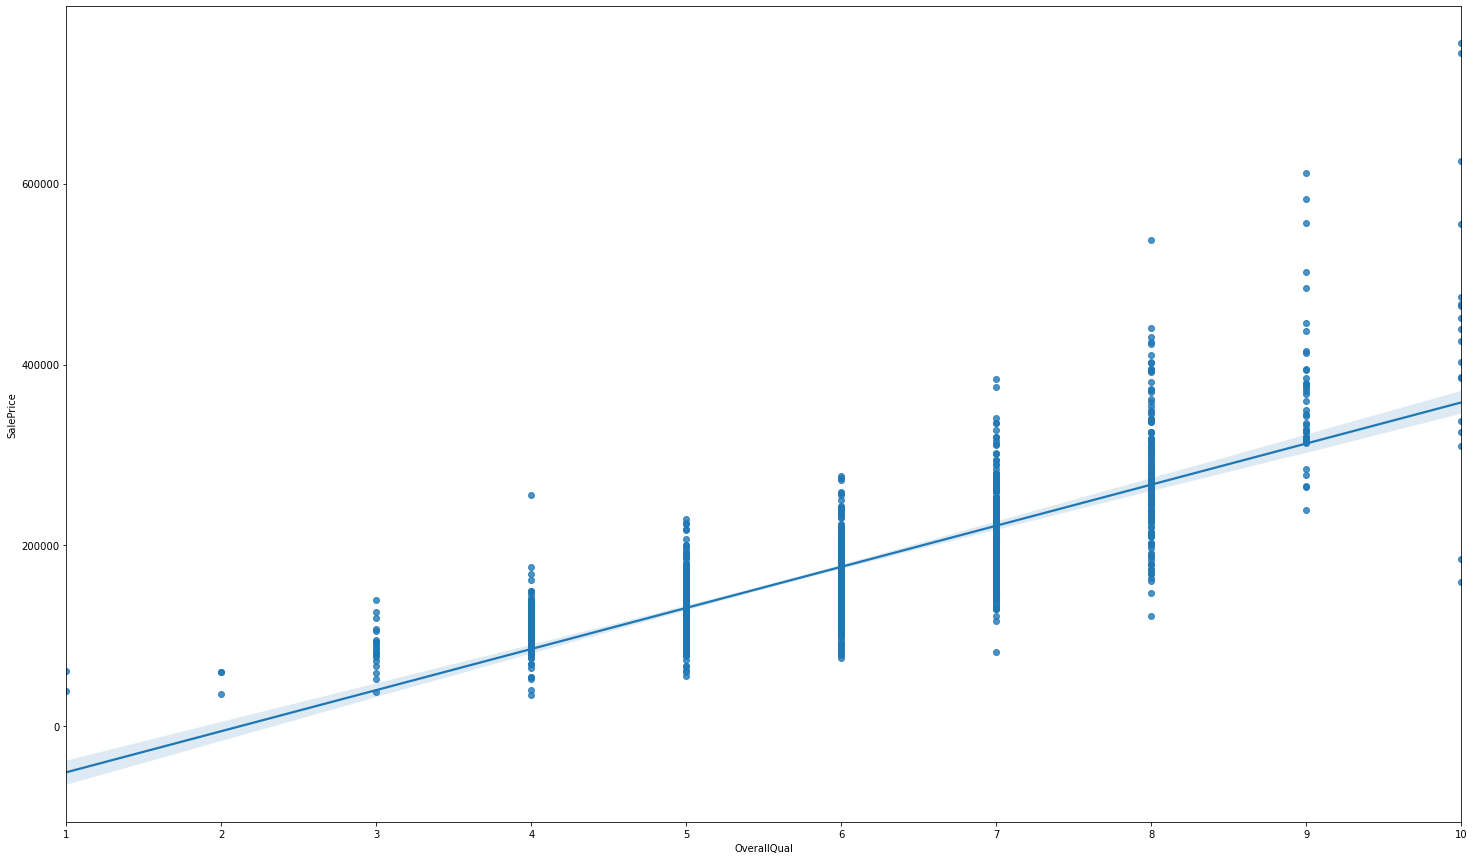

In [109]:
# The regression plot shows a positive correlation between OverallQual and SalePrice

fig, ax = plt.subplots(figsize=(25,15))

sns.regplot(data=housing_copy, 
             x="OverallQual", 
             y="SalePrice", 
             ax=ax);


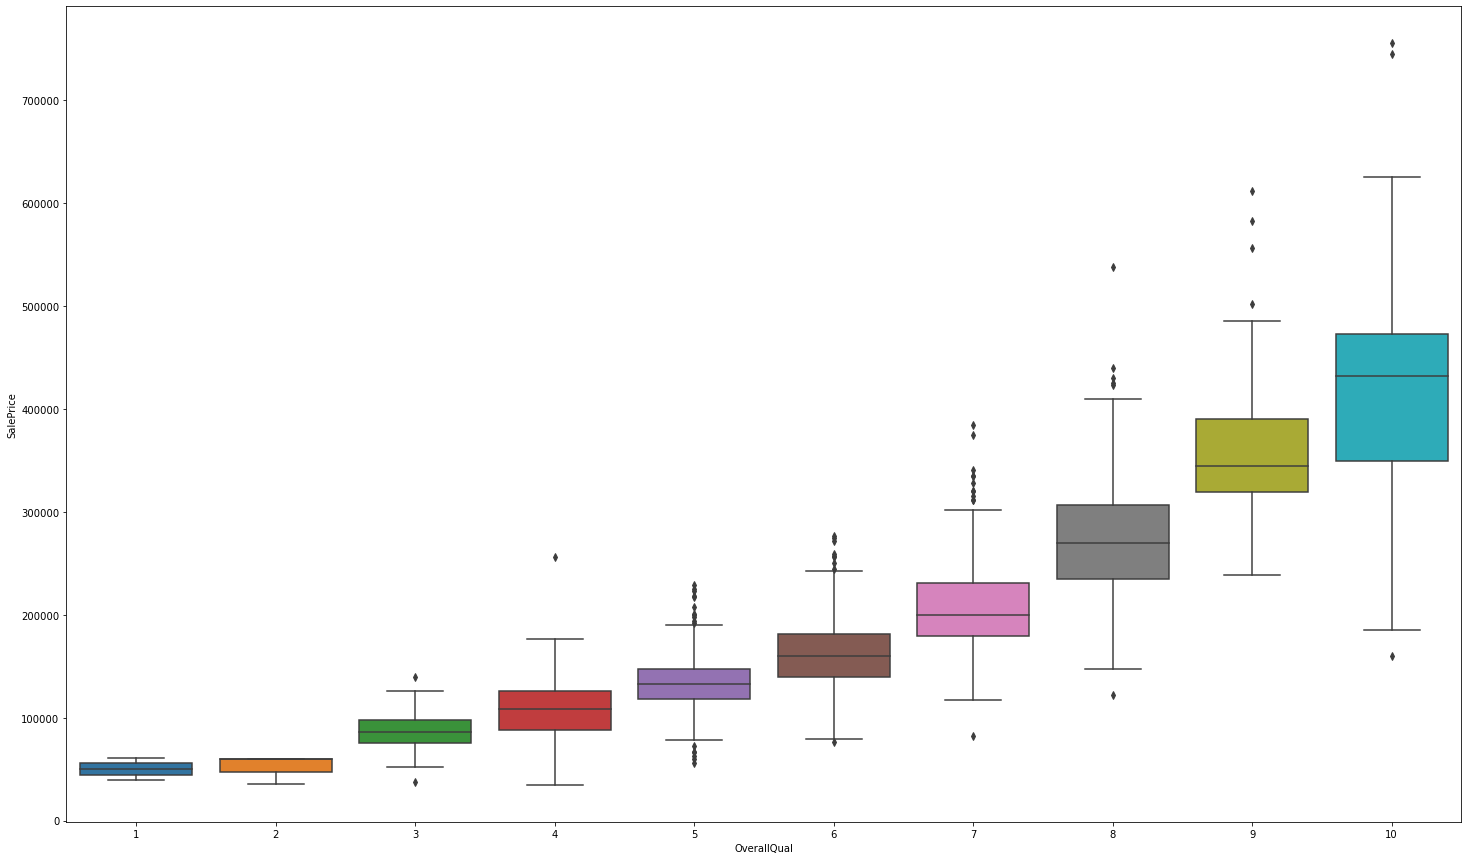

In [91]:
# Was also interested in seeing the variation
# The higher the OverallQual, the higher the SalePrice and median.
# The highest OverallQual also has a greater variation than lower scores, and 2 outliers in the higher price range

fig, ax = plt.subplots(figsize=(25,15))

sns.boxplot(data=housing_copy, 
             x="OverallQual", 
             y="SalePrice", 
             ax=ax);

In [106]:
housing_copy["OverallQual"].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

### Let's check the top 5 positive correlations with SalePrice (from the numerical columns)

In [158]:
# top 5

housing_copy.corr()["SalePrice"].sort_values(ascending=False).head(6)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

In [122]:
x2 = sm.add_constant(housing_copy[["OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF"]])
model2 = sm.OLS(housing_copy["SalePrice"], x2)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     926.5
Date:                Sat, 12 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:06:29   Log-Likelihood:                -17499.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.907e+04   4638.450    -21.359      

low: 0-0.3 / moderate: 0.3-0.7 / high: 0.7-1

Adj. R-squared: 0.760
        
Now we have to look at the adjusted R squared, because we do a multicolinearity regression. The adjusted R-squared of 0.760 indicates that OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF together account for 76% of variation in sale price. This is a high positive correlation.
This is an increase of (0.760 - 0.626 =) 0.134 compared to the previous regression with only 1 factor: OverallQual.

Given our data, assuming the null hypothesis (which is 0), the likelihood of obtaining the regression coefficient that we observed or more extreme is 0.000 for all factors except for GarageArea, which has 0.102. Since all these values are below the Alpha level of 5%, it is statistically significant and we can reject the null hypothesis.

## Does the neighborhood have an influence on the sales price? Let's have a look at a non numerical column

I assume that the neighborhood would have an influence on the sale price. Let's check this assumption.

In [33]:
housing_copy["Neighborhood"].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [160]:
len(housing_copy["Neighborhood"].unique())

25

In [148]:
housing_copy.value_counts("Neighborhood")

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
dtype: int64

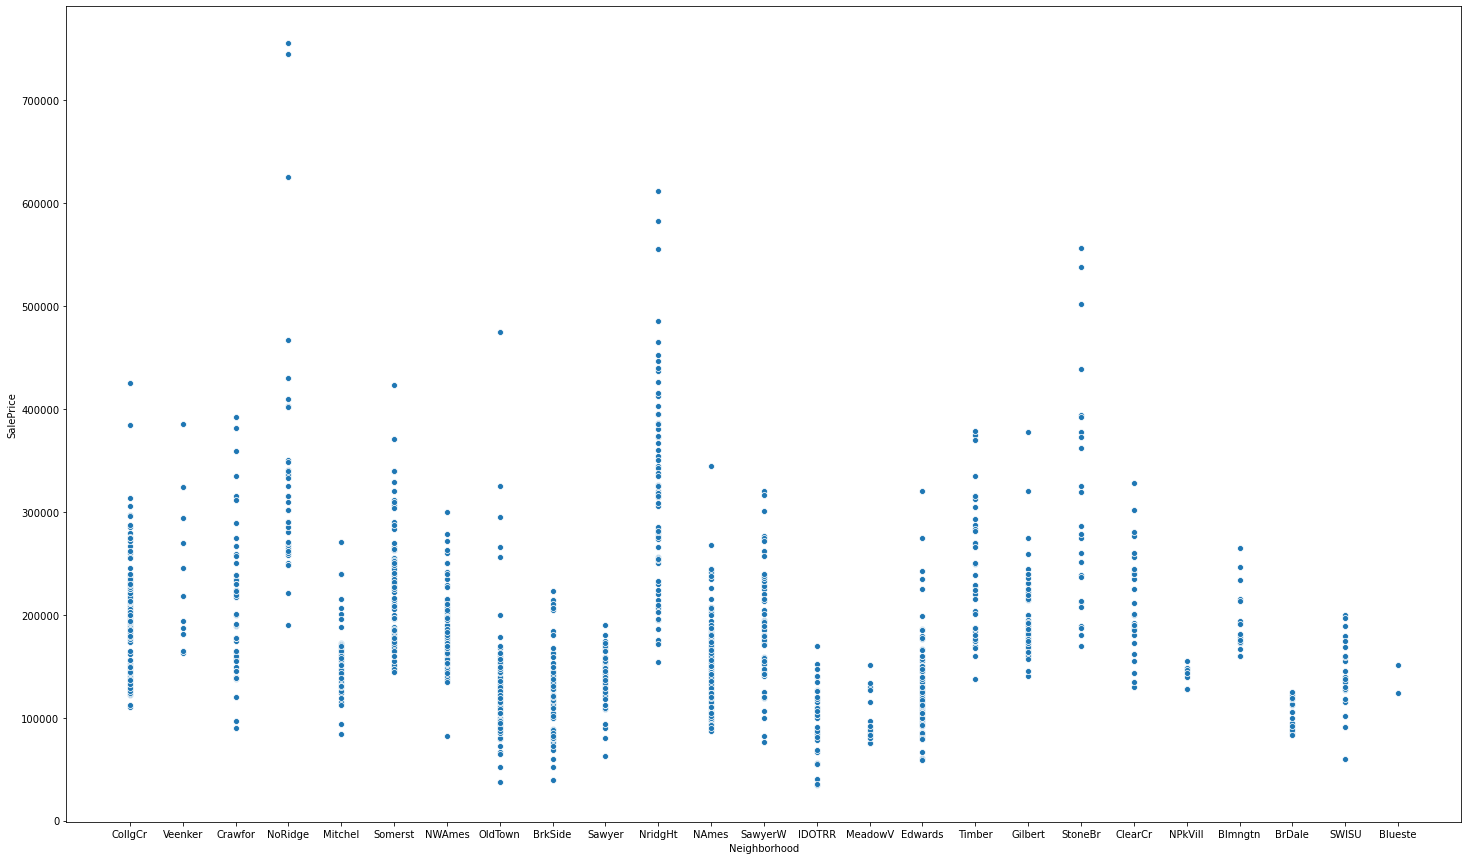

In [171]:
# The graph below shows sale prices for various neighborhoods, not sorted

fig, ax = plt.subplots(figsize=(25,15))

sns.scatterplot(data=housing_copy, 
             x="Neighborhood", 
             y="SalePrice", 
             ax=ax);

### Need to create dummy variables in order to check the regression

In [124]:
dummy = pd.get_dummies(housing_copy["Neighborhood"])

In [125]:
dummy.head()

,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [128]:
dummy.columns

Index(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU',
       'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'],
      dtype='object')

### Add new 'dummy columns' to the original dataframe to be able to check them against SalePrice

In [126]:
housing_copy = pd.concat([housing_copy, dummy], axis=1)

In [127]:
housing_copy.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,0,0,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,0,0,0,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,0,0,0,0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,0,0,0,0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,1,0,0,0,0,0,0,0,0,0


In [129]:
x3 = sm.add_constant(housing_copy[['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU',
       'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']])
model3 = sm.OLS(housing_copy["SalePrice"], x3)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     71.78
Date:                Sat, 12 Sep 2020   Prob (F-statistic):          1.56e-225
Time:                        15:39:38   Log-Likelihood:                -17968.
No. Observations:                1460   AIC:                         3.599e+04
Df Residuals:                    1435   BIC:                         3.612e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.769e+05   2316.697     76.354      0.0

low: 0-0.3 / moderate: 0.3-0.7 / high: 0.7-1

Adj. R-squared: 0.538
        
We have to look at the adjusted R-squared, because we do a multicolinearity regression. The adjusted R-squared of 0.538 indicates that all neighborhoods together account for 53.8% of variation in sale price. This is a moderate positive correlation.
Compared to the top 5 positive correlations (of numerical columns), this is a decrease of (0.760 - 0.538 =) 0.222.

Given our data, assuming the null hypothesis (which is 0), the likelihood of obtaining the regression coefficient that we observed or more extreme is 0.000 for most factors except for the following areas: Blmngtn (0.160), Blueste (0.284), Gilbert (0.011), Mitchel (0.008), NPkVill (0.050), NWAmes (0.062), SWISU (0.001), SawyerW (0.176). Since all these values are below the Alpha level of 5%, it is statistically significant and we can reject the null hypothesis.

## Out of curiosity: Let's graphically compare the top 5 positive correlations with the 5 closest to 0 (both for numerical columns)

### Top 5 positive correlations

The top 5 positive correlations are: OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF.
The pairplot shows positive correlations for these factors and the SalePrice. 

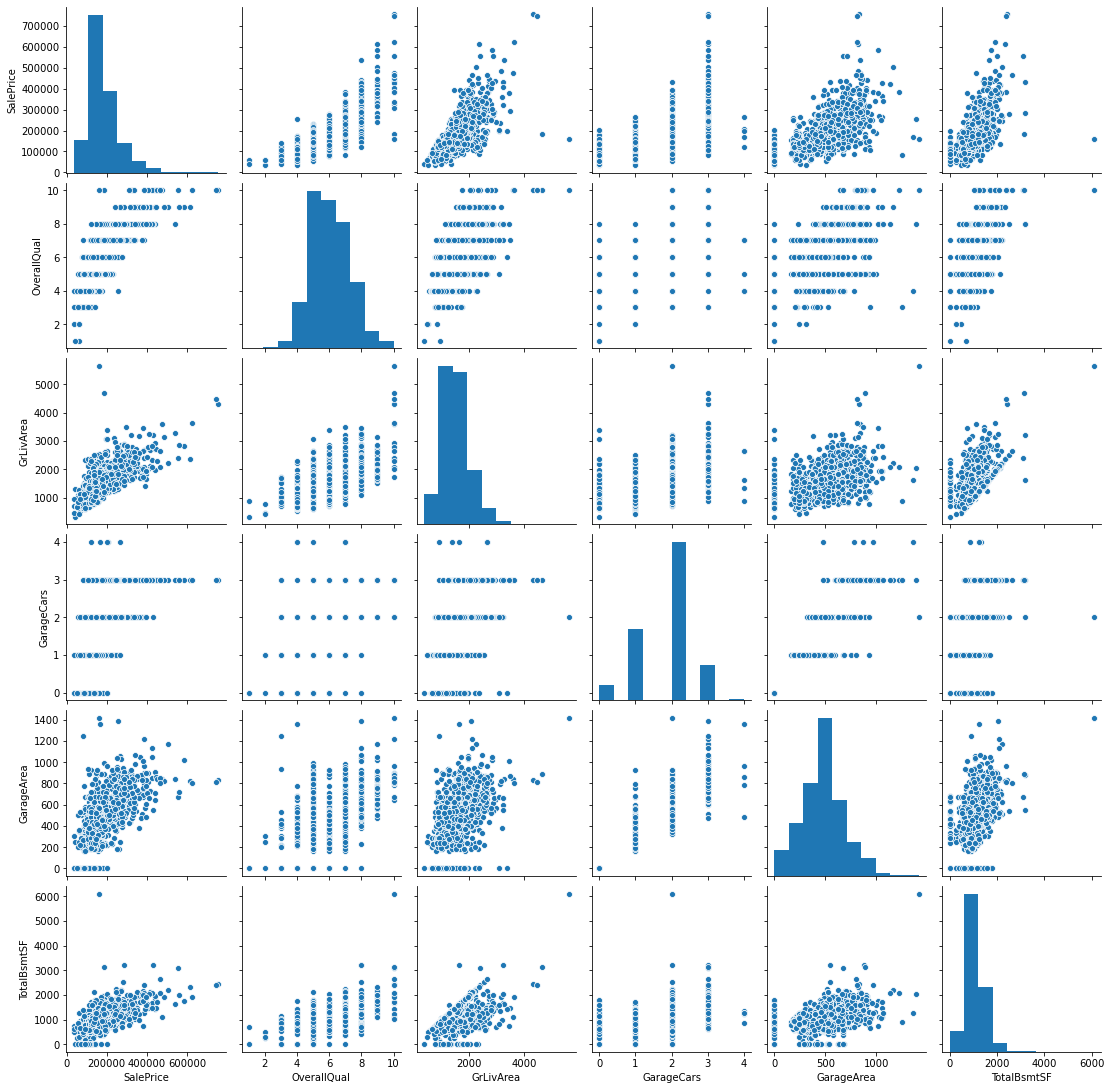

In [136]:
sns.pairplot(housing_copy[["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF"]])

### 5 correlations closest to 0

The 5 correlations closest to 0 are: BsmtFinSF2, BsmtHalfBath, MiscVal, Id, LowQualFinSF.
Compared to the top 5 positive correlations, this pairplot shows barely to no correlations for these factors and the SalePrice. 

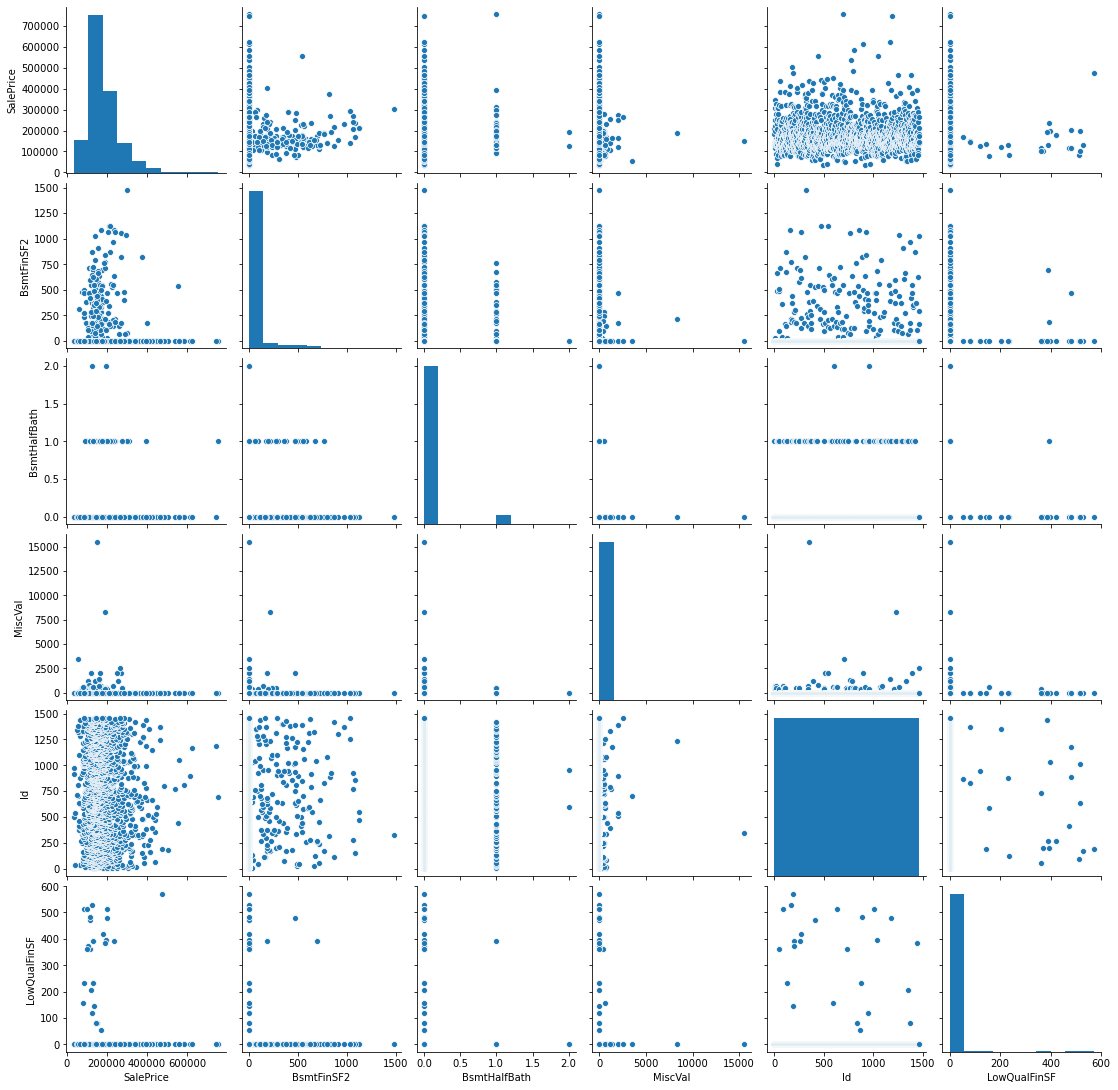

In [138]:
sns.pairplot(housing_copy[["SalePrice", "BsmtFinSF2", "BsmtHalfBath", "MiscVal", "Id", "LowQualFinSF"]])